<div class="alert alert-success">
    -----
</div>

# Abstract

# Introduction

# `Analysis`

## Imports

In [321]:
import sys

In [322]:
from functools import lru_cache

---

In [323]:
import numpy as np

In [324]:
import pandas as pd

In [325]:
from scipy import optimize
import scipy.stats as st

In [326]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

---

In [327]:
import matplotlib.pyplot as plt

In [328]:
import seaborn as sns

---

In [329]:
from tqdm import tqdm

In [330]:
from IPython.display import display

---

In [331]:
import warnings
warnings.filterwarnings("ignore")

## Data Reading and Pre-Processing

In [332]:
data = pd.read_csv('ccs2022.csv')
data.rename(columns={'Unnamed: 0':'semi_global_trial'}, inplace=True)

In [333]:
# Check for empty values
data.isna().any();

In [334]:
# Add column to mark when J is the correct response
data['J_correct'] = (data['yj'] > data['yf']).map(int)

In [335]:
# Add column to mark when a correct choice was made
data['correct'] = data['J_correct'] & data['J_pressed']

In [336]:
# Create unique task identifier for all participants
data['global_task'] = 100*data['slow'] + data['task']

In [337]:
data.head()

,semi_global_trial,num_features,task,trial,w0,w1,w2,w3,xf0,xf1,...,xj3,yf,yj,slow,J_pressed,decision_time,participant_id,J_correct,correct,global_task
0,0,2,1,1,-0.442305,-1.614365,0.0,0.0,0.151539,-0.325901,...,0.0,0.459097,1.784513,1,1,2555,0,1,1,101
1,1,2,1,2,-0.442305,-1.614365,0.0,0.0,-1.500723,0.559236,...,0.0,-0.239034,-1.642405,1,1,1203,0,0,0,101
2,2,2,1,3,-0.442305,-1.614365,0.0,0.0,0.398691,0.523985,...,0.0,-1.022246,0.896446,1,1,813,0,1,1,101
3,3,2,1,4,-0.442305,-1.614365,0.0,0.0,0.715695,-0.925789,...,0.0,1.178006,4.049918,1,1,917,0,1,1,101
4,4,2,1,5,-0.442305,-1.614365,0.0,0.0,2.294209,1.454999,...,0.0,-3.363640,-2.712185,1,1,1278,0,1,1,101


## Global Constants

In [338]:
NUM_TRIALS = data['trial'].nunique()

In [339]:
NUM_PARTICIPANTS = data['participant_id'].nunique()
PARTICIPANTS = data['participant_id'].unique().astype(int)

---

In [340]:
PRINT_ENABLE = False

## Global Functions

In [341]:
def detect_outliers(x):
    q1 = np.quantile(x, 0.25) # Lower quartile
    q3 = np.quantile(x, 0.75) # Upper quartile
    
    iqr = q3-q1 # Interquartile range
    
    iqr_bounds = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)] # Bounds
    
    outliers = x[(x <= iqr_bounds[0]) | (x >= iqr_bounds[1])] # Selecting data beyond bounds
    
    return outliers

In [342]:
def print_(*args, **kwargs):
    if PRINT_ENABLE:
        print(*args, **kwargs)

<div class="alert alert-success">
    Choosing BIC as performance measure because the aim is to have the best fitting model or highest posterior probability.
</div>

In [343]:
epsilon_greedy = lambda choice_function: lambda e: lambda *args, **kwargs: choice_function(*args, **kwargs) * (1 - e) + 0.5 * e

In [344]:
@epsilon_greedy
def softmax(s1, s2, *std): # Softmax Rule
    return 1/(1 + np.e**(s1 - s2))

In [345]:
@epsilon_greedy
def am(s1, s2, *std): # Accuracy Maximization
    return s1 < s2

In [346]:
@epsilon_greedy
def pm(s1, s2, std1, std2):
    return np.random.normal(s1, std1) < np.random.normal(s2, std2)

In [347]:
@epsilon_greedy
def sb(s1, s2, std1, std2, n_samples=10):
    return np.count_nonzero(np.random.normal(s1, std1, (1, n_samples)) > np.random.normal(s2, std2, (1, n_samples))) >= n_samples/2

In [348]:
def boxplot(a, b, box_labels, ax, point_labels=PARTICIPANTS):
    df = pd.DataFrame(np.array([np.array(a).flatten(), np.array(b).flatten()]).T, columns=box_labels)
    sns.boxplot(data=df, ax=ax, boxprops=dict(alpha=.3))
    sns.swarmplot(data=df, ax=ax)

    for i, k in enumerate(point_labels):
        ax.text(0, a[i], k, alpha=0.8)
        ax.text(1, b[i], k, alpha=0.8)

In [349]:
## > BIC = p.(f.ln(t.k) - 2.LL)
## >> LL = ln(1/2).t.k
bic = lambda P, N, LL: P*np.log(N) - 2*LL

In [350]:
# @lru_cache
def fit_model(participant_id,
              Model,
              model_params,
              choice_function=am(0),
              conditions={},
              feature_labels=[['xf0', 'xf1', 'xf2', 'xf3'], ['xj0', 'xj1', 'xj2', 'xj3']],
              target_labels=[['yf'], ['yj']],
              choice_label='J_pressed'):

    data_participant = data[data['participant_id'] == participant_id]
    if conditions:
        for condition in conditions:
            data_participant = data_participant[data_participant[condition] == conditions[condition]]

    ## num_tasks = data_participant['global_task'].nunique() # Find number of tasks
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    log_likelihoods = {} # [num_tasks]
    for task in tasks: # For each task
        data_participant_task = data_participant[data_participant['global_task'] == task] # Focus on that task data

        num_features = int(data_participant_task['num_features'].unique()) # Find number of inputs for that task
        
        model = Model(num_features, *model_params) # Create Model instance with the number of inputs and passed model parameters

        log_likelihood = []
        for trial in data_participant_task['trial'].unique(): # For each trial
            data_participant_task_trial = data_participant_task[data_participant_task['trial'] == trial] # Focus on that trial data

            # Extract input and target arrays, and choice, using (default) labels passed in function call
            inputs = [data_participant_task_trial[feature_labels_i[:num_features]].to_numpy().reshape((-1, 1)) for feature_labels_i in feature_labels]
            targets = [data_participant_task_trial[target_labels_i].to_numpy().reshape((-1, 1)) for target_labels_i in target_labels]

            # Make predictions
            means, std = np.array([np.array(model.predict(inputs_i)).flatten() for inputs_i in inputs]).T

            # Learn model
            for inputs_i, target in zip(inputs, targets):
                model.learn(inputs_i, target)

            # Make decision
            p_choice = choice_function(*means, *std)

            likelihood = p_choice if int(data_participant_task_trial[choice_label]) == 1 else 1-p_choice
            
            # Calculate log-likelihood
            log_likelihood.append(np.log(likelihood if likelihood else sys.float_info.min)) # corresponding to the lowest log(float) possible

        log_likelihoods[task] = log_likelihood

    return log_likelihoods

In [351]:
def pick_tasks(participant_id, conditions={}): # {'num_features': 2}, {'num_features': 3}, {'num_features': 4}, {'slow': 1}, {'slow': 0}
    # def create_condition(key, param):
    #     if key == 'all':
    #         return []
    #     else:
    #         try:
    #             return {key: int(param)}
    #         except ValueError:
    #             raise ValueError('Invalid Condition!')

    data_participant = data[data['participant_id'] == participant_id]
    
    if conditions: # If there are conditions
        for condition in conditions: # Apply conditions iteratively
            data_participant = data_participant[data_participant[condition] == conditions[condition]]
    
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    return tasks

In [352]:
def no_search(func, rrange):
    return np.arange(*rrange[0])[0], func(np.arange(*rrange[0])[:1])

In [381]:
def optimise(Model,
             model_search_space = (),
             search_algorithm=lambda *args, **kwargs: optimize.brute(*args, **kwargs, full_output=True, finish=None),
             error_search_space=(0, 1, 0.1),
             choice_function=softmax,
             conditions={}):
    
    if len(model_search_space) != Model._num_params:
        raise ValueError(f'Not enough model search parameters specified. Required {Model._num_params} parameters.')
    
    bics = []
    optimal_model_params = []
    optimal_error = []
        
    for participant_id in tqdm(data['participant_id'].unique()):
        tasks = pick_tasks(participant_id, conditions)

        def llfunc(model_error_params):
            log_likelihoods = fit_model(participant_id, Model, tuple(model_error_params)[:-1], choice_function(model_error_params[-1]) , conditions)
            return -sum([sum(log_likelihoods[task]) for task in tasks])
        
        optimal_model_error_params, fval, *_ = search_algorithm(llfunc, model_search_space + (error_search_space,))

        bics.append(bic(len(model_search_space)+1, len(tasks)*NUM_TRIALS, -fval))
        optimal_model_params.append(optimal_model_error_params[:-1])
        optimal_error.append(optimal_model_error_params[-1])
    
    return np.array(bics), np.array(optimal_model_params), np.array(optimal_error)

## Outlier Detection

The most important columns for analysis are participant accuracy and reaction time as these reflect performance in the experiment.

### Outlier Detection (Accuracy)

In [354]:
# Average accuracy
avg_correct = data['correct'].mean()
print_(f'Average accuracy: {avg_correct:.3f}')

In [355]:
# Participant accuracy
par_correct = data.groupby('participant_id').correct.mean()
print_(par_correct.to_frame())

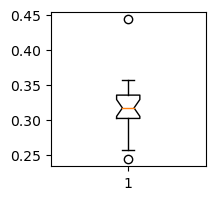

In [356]:
plt.figure(figsize=(2, 2))
plt.boxplot(par_correct, notch=True);

After taking a look at the accuracy data we found one outlier performing well above others. We identify this as participant number 18.

In [357]:
print_(detect_outliers(par_correct))

### Outlier Detection (Reaction Time)

In [358]:
par_RT = data.groupby('participant_id').decision_time.mean()
print_(par_RT.to_frame())

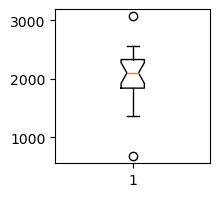

In [359]:
plt.figure(figsize=(2, 2))
RTBox = plt.boxplot(par_RT, notch=True)

We also note two outliers in reaction time data, with participants 18 and 11 having exceptionally fast and slow reaction times, respectively.

In [360]:
print_(detect_outliers(par_RT));

### Excluding Outliers

We decided to exclude only participant 18 due to having both higher accuracy and lower RT than all other participants. However, we keep participant 11 in the data as despite their slow reaction times their performance was not exceptional.

In [361]:
data_ = data[data['participant_id'] != 18] # Excluding participant 18

In [362]:
# Computing new means after exclusion
avg_correct = data_['correct'].mean()
par_correct = data_.groupby('participant_id').correct.mean()
par_RT = data_.groupby('participant_id').decision_time.mean()

## Behavioral Analysis

#### Do participants perform better than chance?

In [363]:
print_(f'Average accuracy: {avg_correct}')
t_par, p_par = st.ttest_1samp(par_correct, 0.5)
print_(f't = {t_par} ; p = {p_par}')

A one-sample t-test against a 50% chance level (participants had two alternatives) reveals that participants performed statistically significantly above chance level ($t$ = 9.75, $p$ < 0.05) with an average accuracy of 63.3%.

#### Do they improve over trials within each round?

In [364]:
data_.groupby('trial').correct.mean();

In [365]:
smf.ols(formula='correct ~ trial', data=data_).fit().summary();

A linear regression analysis indicated that participants performed better trial-wise within blocks ($\beta$ = 0.014, $R^2$ = 0.007, $p$ < 0.001), performing on average 1.4% better each trial after the first.

#### Do they improve over rounds?

In [366]:
data_.groupby(['task', 'slow']).correct.mean();

In [367]:
smf.ols(formula='correct ~ task', data=data_).fit().summary();

We also performed a linear regression analysis to test whether participants performed better at the start of the experiment but found no statistically significant influence of task ($p$ = 0.242).

#### How does the number of observed features affect performance?

In [368]:
data_.groupby('num_features').correct.mean();

In [369]:
smf.ols(formula='correct ~ num_features', data=data_).fit().summary();

We found that the number of features has a statistically significant influence on participant accuracy ($\beta$ = -0.043, $R^2$ = 0.005, $p$ < 0.001), with the addition of each feature decreasing accuracy on average by 4.3%.

#### How does time pressure affect performance?

In [370]:
data_.groupby('slow').correct.mean();

In [371]:
t_slow_fast, p_slow_fast = st.ttest_rel(data_[data_['slow'] == 0].correct, data_[data_['slow'] == 1].correct)
print_(f't = {t_slow_fast}, p = {p_slow_fast}')

Participants also had better accuracy in slow trials over regular trials as indicated by an independent samples t-test ($df$ = 17, $t$ = -3.5, $p$ < 0.001), performing on average 4.5% better in slow trials.

### Does RT affect performnce?

In [372]:
data_.groupby('participant_id')[['decision_time', 'correct']].mean();

In [373]:
st.pearsonr(par_correct, par_RT);

In [374]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

We found a significant negative relationship between accuracy and reaction time.

### Bigression

In [375]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

## Parameter Fitting

`Look at the resulting parameters and try to answer the following questions`

### Random Model

In [ ]:
# bics_rm = np.array([bic(0, NUM_TRIALS*data['global_task'].nunique(), NUM_TRIALS*data['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [376]:
bics_rm_slow = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [377]:
bics_rm_fast = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

### Rescorla-Wagner

In [378]:
class RescorlaWagner():
    _num_params = 1

    def __init__(self, num_features, learning_rate):
        self.num_features = num_features
        self.learning_rate = learning_rate
        
        self.weights = np.zeros((num_features, 1))
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        return mean, [[0]]
        
    def learn(self, inputs, targets):
        self.weights = self.weights + self.learning_rate * (targets - self.weights.T @ inputs) * inputs

In [ ]:
# bics_rw, optimal_model_params_rw, optimal_error_rw = optimise(RescorlaWagner, ((0, 1, 0.1),))

In [382]:
bics_rw_slow, optimal_model_params_rw_slow, optimal_error_rw_slow = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 1})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [10:58<00:00, 34.67s/it]


In [383]:
bics_rw_fast, optimal_model_params_rw_fast, optimal_error_rw_fast = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 0})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [10:37<00:00, 33.55s/it]


#### Does time pressure lead to slower learning?

Compare learning rate in slow vs fast tasks.

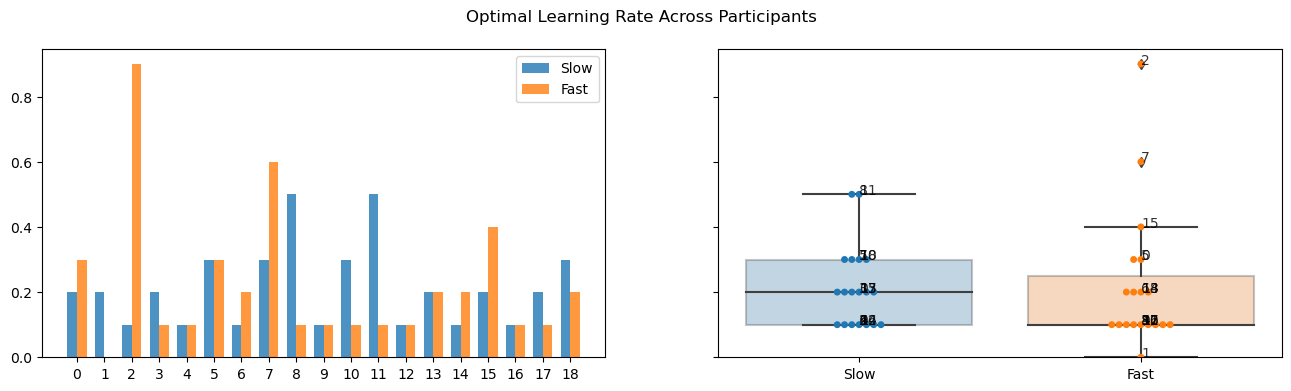

In [384]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Learning Rate Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_rw_slow[:, 0], 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_rw_fast[:, 0], 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend();

boxplot(optimal_model_params_rw_slow, optimal_model_params_rw_fast, ('Slow', 'Fast'), ax[1])

In [385]:
st.ttest_rel(optimal_model_params_rw_slow[:, 0], optimal_model_params_rw_fast[:, 0])

Ttest_relResult(statistic=-0.08778086039709782, pvalue=0.9310200641355209)

#### Does time pressure lead to more noisy decisions?

Compare $\epsilon$-error parameter in slow vs fast tasks.

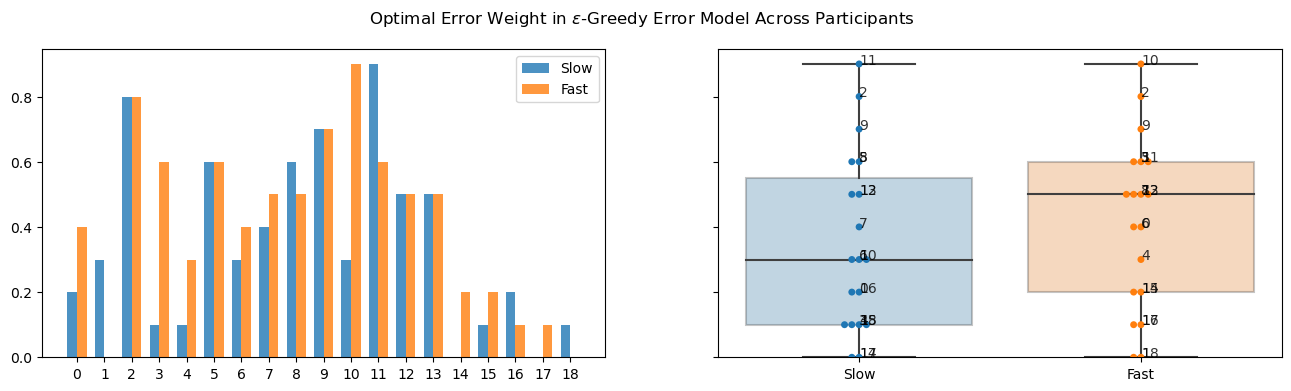

In [386]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_error_rw_slow, 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_error_rw_fast, 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend();

boxplot(optimal_error_rw_slow, optimal_error_rw_fast, ('Slow', 'Fast'), ax[1])

In [387]:
st.ttest_rel(optimal_error_rw_slow, optimal_error_rw_fast)

Ttest_relResult(statistic=-1.228304149082893, pvalue=0.23515194023543776)

### Kalman Filter

In [158]:
class KalmanFilter():
    _num_params = 2 
    
    def __init__(self, num_features, sigma_y, sigma_w):
        self.num_features = num_features
        self.sigma_y = sigma_y
        self.sigma_w = sigma_w
        
        self.weights = np.zeros((num_features, 1))
        self.covariance = sigma_w * np.eye(num_features)
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        std = np.sqrt(inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        return mean, std

    def learn(self, inputs, targets):
        kalman_numerator = self.covariance @ inputs
        kalman_denominator = inputs.T @ self.covariance @ inputs + self.sigma_y ** 2
        kalman_gain = kalman_numerator / kalman_denominator
        
        self.weights = self.weights + kalman_gain * (targets - self.weights.T @ inputs)
        self.covariance = self.covariance - kalman_gain @ inputs.T @ self.covariance

In [ ]:
# bics_kf, optimal_model_params_kf, optimal_error_kf = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)))

In [167]:
bics_kf_slow, optimal_model_params_kf_slow, optimal_error_kf_slow = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 1})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:31:06<00:00, 287.74s/it]


In [168]:
bics_kf_fast, optimal_model_params_kf_fast, optimal_error_kf_fast = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 0})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:27:09<00:00, 275.21s/it]


#### Does time pressure lead to slower learning?

Compare $\sigma_y$ in slow vs fast tasks.

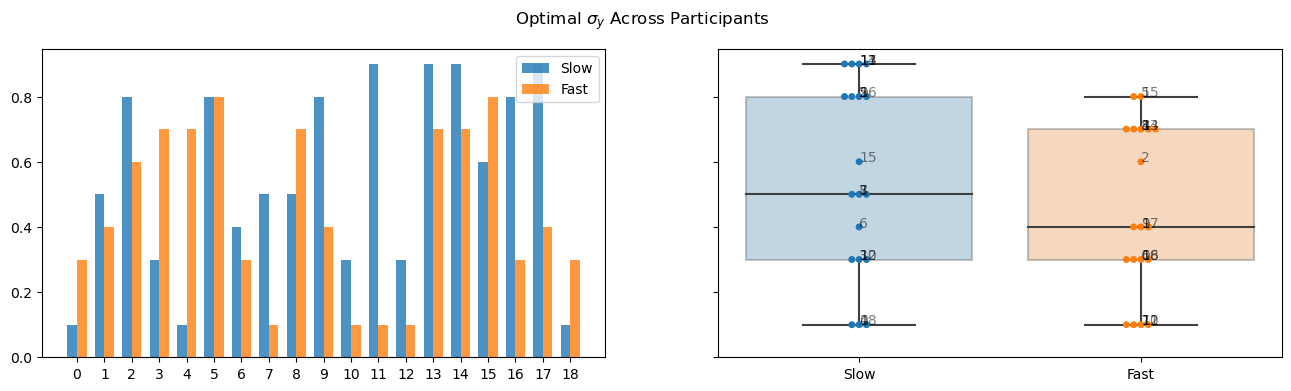

In [289]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal $\sigma_y$ Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_kf_slow[:, 0], 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_kf_fast[:, 0], 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend();

boxplot(optimal_model_params_kf_slow[:, 0], optimal_model_params_kf_fast[:, 0], ('Slow', 'Fast'), ax[1])

In [296]:
st.ttest_rel(optimal_model_params_kf_slow[:, 0], optimal_model_params_kf_fast[:, 0])

Ttest_relResult(statistic=1.3277716193177278, pvalue=0.20084696514267514)

#### Does time pressure lead to more noisy decisions?

Compare $\epsilon$-error parameter in slow vs fast tasks.

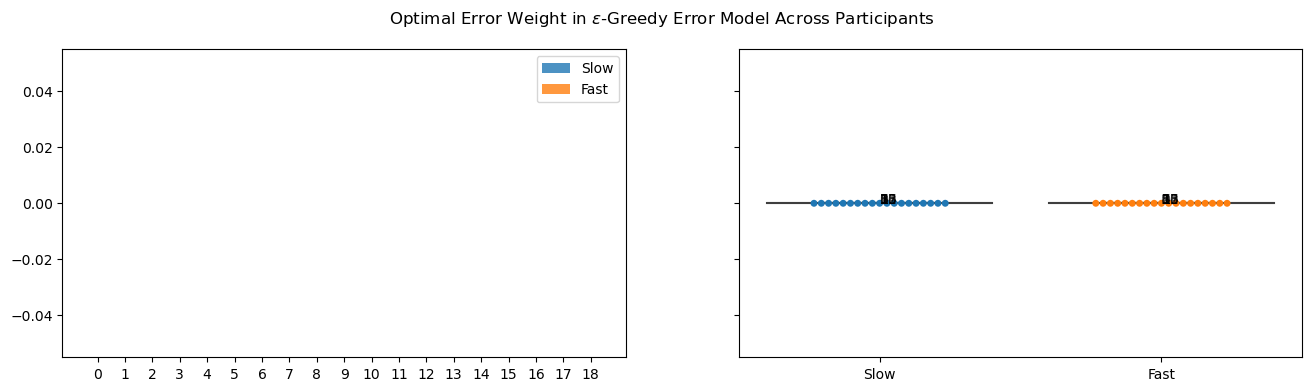

In [298]:
fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
ax[0].bar(PARTICIPANTS - 0.175, np.array(optimal_error_kf_slow).squeeze(), 0.35, label='Slow', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.175, np.array(optimal_error_kf_fast).squeeze(), 0.35, label='Fast', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend();

boxplot(optimal_error_kf_slow, optimal_error_kf_fast, ('Slow', 'Fast'), ax[1])

In [ ]:
st.ttest_rel(optimal_error_kf_slow, optimal_error_kf_fast)

## Model Comparison

In [407]:
bics_slow = pd.DataFrame({'RW_SLOW': bics_rw_slow, 'KF_SLOW': bics_kf_slow, 'RM_SLOW': bics_rm_slow}).applymap(round)
bics_fast = pd.DataFrame({'RW_FAST': bics_rw_fast, 'KF_FAST': bics_kf_fast, 'RM_FAST': bics_rm_fast}).applymap(round)

In [389]:
counts_slow = {'RW_SLOW': 0, 'KF_SLOW': 0, 'RM_SLOW': 0}
for key, val in zip(*np.unique(bics_slow.columns[np.argmin(np.array(bics_slow), axis=1)], return_counts=True)):
    counts_slow[key] = val

counts_fast = {'RW_FAST': 0, 'KF_FAST': 0, 'RM_FAST': 0}
for key, val in zip(*np.unique(bics_fast.columns[np.argmin(np.array(bics_fast), axis=1)], return_counts=True)):
    counts_fast[key] = val

#### Which model explains the human data best?

Compare BIC scores for all models in slow and fast tasks.

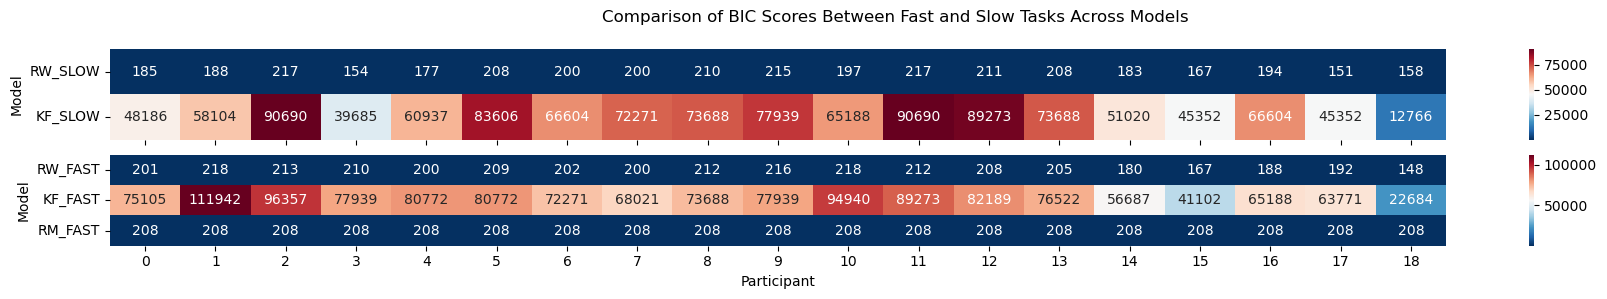

In [408]:
fig, axs = plt.subplots(2, 1, figsize=(18, 3), sharex=True)

sns.heatmap(bics_slow[['RW_SLOW', 'KF_SLOW']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[0])
# axs[0].set_title('BIC (Slow Tasks)')
# axs[0].set_xlabel('Participant')
axs[0].set_ylabel('Model')

sns.heatmap(bics_fast[['RW_FAST', 'KF_FAST', 'RM_FAST']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[1])
# axs[1].set_title('BIC (Fast Tasks)')
axs[1].set_xlabel('Participant')
axs[1].set_ylabel('Model')

fig.suptitle('Comparison of BIC Scores Between Fast and Slow Tasks Across Models')

plt.tight_layout()

#### Does time pressure lead to simpler learning strategies?

Compare the complexity of models based on percentage of wins in slow vs fast tasks.

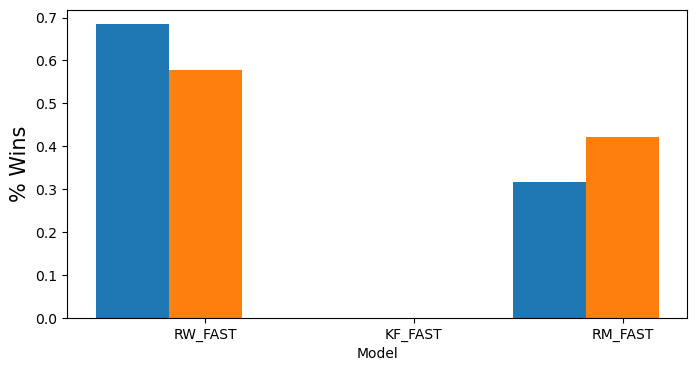

In [391]:
plt.figure(figsize=(8, 4))

plt.bar(np.arange(len(counts_slow)) - 0.175, list(counts_slow.values())/sum(list(counts_slow.values())), 0.35, tick_label=list(counts_slow.keys()))
plt.bar(np.arange(len(counts_fast)) + 0.175, list(counts_fast.values())/sum(list(counts_fast.values())), 0.35, tick_label=list(counts_fast.keys()))
plt.xlabel('Model')
plt.ylabel('% Wins', fontsize=15);

# Methods

# Results

# Discussion

# References